In [ ]:
!nvidia-smi

In [2]:
import torch

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("MPS is availabe.")

MPS is availabe.


In [1]:
!pip install ultralytics


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import cv2, os, random, shutil
import numpy as np
from ultralytics import YOLO
from matplotlib import pyplot as plt

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedatasith/sku110k-annotations")

print("Path to dataset files:", path)

Path to dataset files: /Users/chenarei/.cache/kagglehub/datasets/thedatasith/sku110k-annotations/versions/14


In [7]:
def subsample_data(source_path, target_path, num_samples):
    # Specify directory paths
    image_path_suffix = ["images/train/", "images/val/", "images/test/"]
    label_path_suffix = ["labels/train/", "labels/val/", "labels/test/"]

    chosen_image_paths, chosen_label_paths = [], []

    for i in range(3):
        source_image_dir = source_path+image_path_suffix[i]
        source_label_dir = source_path+label_path_suffix[i]
        target_image_dir = target_path+image_path_suffix[i]
        target_label_dir = target_path+label_path_suffix[i]

        # Create directories for the subset
        os.makedirs(target_image_dir, exist_ok=True)
        os.makedirs(target_label_dir, exist_ok=True)

        # Get a list of all file names in the specified directory
        file_names = os.listdir(source_image_dir)

        # Randomlly choose some image examples
        random.seed(88)
        chosen_file_names = random.choices(file_names, k=num_samples[i])

        for file_path in chosen_file_names:
            shutil.copy(source_image_dir+file_path, target_image_dir+file_path)
            shutil.copy(source_label_dir+file_path[:-3]+"txt", target_label_dir+file_path[:-3]+"txt")
            chosen_image_paths.append(target_image_dir+file_path)
            chosen_label_paths.append(target_label_dir+file_path[:-3]+"txt")

    print(chosen_image_paths)
    print(chosen_label_paths)

    return chosen_image_paths, chosen_label_paths

image_paths, label_paths = subsample_data(path+"/SKU110K_fixed/", "./01_datasets/", [40, 10, 10])

['./01_datasets/images/train/train_7271.jpg', './01_datasets/images/train/train_1728.jpg', './01_datasets/images/train/train_2363.jpg', './01_datasets/images/train/train_5255.jpg', './01_datasets/images/train/train_6613.jpg', './01_datasets/images/train/train_121.jpg', './01_datasets/images/train/train_3247.jpg', './01_datasets/images/train/train_2511.jpg', './01_datasets/images/train/train_1515.jpg', './01_datasets/images/train/train_802.jpg', './01_datasets/images/train/train_6901.jpg', './01_datasets/images/train/train_5808.jpg', './01_datasets/images/train/train_2035.jpg', './01_datasets/images/train/train_1403.jpg', './01_datasets/images/train/train_3341.jpg', './01_datasets/images/train/train_4294.jpg', './01_datasets/images/train/train_4518.jpg', './01_datasets/images/train/train_4008.jpg', './01_datasets/images/train/train_2987.jpg', './01_datasets/images/train/train_8087.jpg', './01_datasets/images/train/train_6105.jpg', './01_datasets/images/train/train_3824.jpg', './01_datas

./02_preprocess/images/train/train_7271.jpg
./02_preprocess/images/train/train_1728.jpg
./02_preprocess/images/train/train_2363.jpg
./02_preprocess/images/train/train_5255.jpg
./02_preprocess/images/train/train_6613.jpg
./02_preprocess/images/train/train_121.jpg
./02_preprocess/images/train/train_3247.jpg
./02_preprocess/images/train/train_2511.jpg
./02_preprocess/images/train/train_1515.jpg
./02_preprocess/images/train/train_802.jpg
./02_preprocess/images/train/train_6901.jpg
./02_preprocess/images/train/train_5808.jpg
./02_preprocess/images/train/train_2035.jpg
./02_preprocess/images/train/train_1403.jpg
./02_preprocess/images/train/train_3341.jpg
./02_preprocess/images/train/train_4294.jpg
./02_preprocess/images/train/train_4518.jpg
./02_preprocess/images/train/train_4008.jpg
./02_preprocess/images/train/train_2987.jpg
./02_preprocess/images/train/train_8087.jpg
./02_preprocess/images/train/train_6105.jpg
./02_preprocess/images/train/train_3824.jpg
./02_preprocess/images/train/train

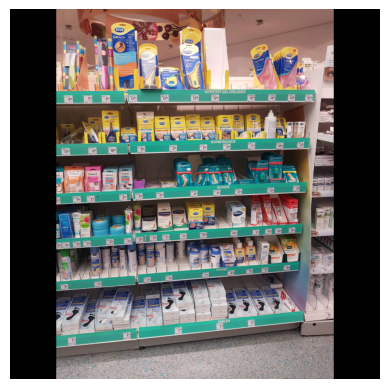

(0.125, 0.0, 0.75, 1.0)


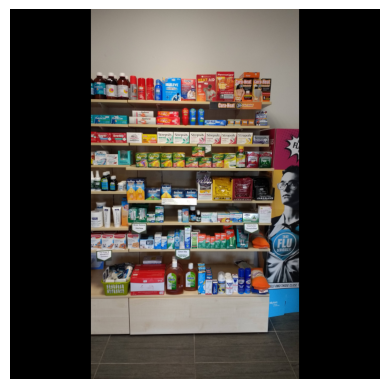

(0.21875, 0.0, 0.5625, 1.0)


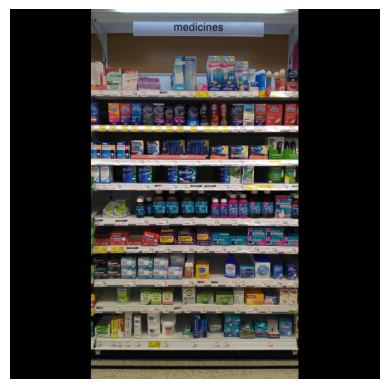

(0.21875, 0.0, 0.5609375, 1.0)


In [8]:
def image_preprocess(image_paths, target_size=(640, 640), pad_color=(0, 0, 0)):
    image_objects, scaling_parameters = [], []
    for image_path in image_paths:
        
        image = cv2.imread(image_path)

        # Compute the scaling factor to resize the image
        original_h, original_w = image.shape[:2]
        target_w, target_h = target_size
        scale = min(target_w/original_w, target_h/original_h)
        scale_w, scale_h = int(original_w*scale), int(original_h*scale)

        # Resize to target size
        image_resized = cv2.resize(image, (scale_w, scale_h), interpolation=cv2.INTER_AREA)

        # Create a new image with the target size and pad color
        padded_image = np.full((target_h, target_w, 3), pad_color, dtype=np.uint8)

        # Compute padding offsets
        pad_top = (target_h - scale_h) // 2
        pad_left = (target_w - scale_w) // 2

        # Place the resized image onto the padded image
        padded_image[pad_top:pad_top+scale_h, pad_left:pad_left+scale_w] = image_resized

        image_objects.append(padded_image)
        scaling_parameters.append((
            pad_left/target_w,
            pad_top/target_h,
            scale_w/target_w,
            scale_h/target_h
        ))

        # Make sure to create the directory if it doesn't exist
        processed_path = image_path.replace("01_datasets", "02_preprocess")
        print(processed_path)
        os.makedirs(os.path.dirname(processed_path), exist_ok=True)
        
        # Write the image to the file
        cv2.imwrite(processed_path, padded_image)

    return image_objects, scaling_parameters

def show_images(input_image):
    # Display the image using matplotlib
    image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

image_objects, scaling_parameters = image_preprocess(image_paths)

for i in range(3):
    show_images(image_objects[i])
    print(scaling_parameters[i])


In [9]:
def prepare_labels(label_paths, scaling_parameters):
    bbox_objects = []
    for label_path, scale in zip(label_paths, scaling_parameters):
        lines = []
        w_pad, h_pad, w_ratio, h_ratio = scale
        with open(label_path, 'r') as fp:
            for line in fp:
                # Split each line and skip the first element, which is class
                bbox = line.split()
                # Convert each value in bbox to float
                bbox = [
                    int(bbox[0]),
                    float(bbox[1])*w_ratio+w_pad,
                    float(bbox[2])*h_ratio+h_pad,
                    float(bbox[3])*w_ratio,
                    float(bbox[4])*h_ratio
                ]
                lines.append(bbox)
        # Make sure to create the directory if it doesn't exist
        processed_path = label_path.replace("01_datasets", "02_preprocess")
        print(processed_path)
        os.makedirs(os.path.dirname(processed_path), exist_ok=True)
        with open(processed_path, 'w') as fp:
            for line in lines:
                fp.write(" ".join(map(str, line))+"\n")
        
        bbox_objects.append(lines)
        print(len(bbox_objects[-1]))
        
    return bbox_objects

bbox_objects = prepare_labels(label_paths, scaling_parameters)

./02_preprocess/labels/train/train_7271.txt
134
./02_preprocess/labels/train/train_1728.txt
125
./02_preprocess/labels/train/train_2363.txt
141
./02_preprocess/labels/train/train_5255.txt
101
./02_preprocess/labels/train/train_6613.txt
231
./02_preprocess/labels/train/train_121.txt
149
./02_preprocess/labels/train/train_3247.txt
165
./02_preprocess/labels/train/train_2511.txt
154
./02_preprocess/labels/train/train_1515.txt
135
./02_preprocess/labels/train/train_802.txt
145
./02_preprocess/labels/train/train_6901.txt
102
./02_preprocess/labels/train/train_5808.txt
132
./02_preprocess/labels/train/train_2035.txt
114
./02_preprocess/labels/train/train_1403.txt
138
./02_preprocess/labels/train/train_3341.txt
138
./02_preprocess/labels/train/train_4294.txt
172
./02_preprocess/labels/train/train_4518.txt
141
./02_preprocess/labels/train/train_4008.txt
75
./02_preprocess/labels/train/train_2987.txt
189
./02_preprocess/labels/train/train_8087.txt
125
./02_preprocess/labels/train/train_6105.txt

Number of labels = 134


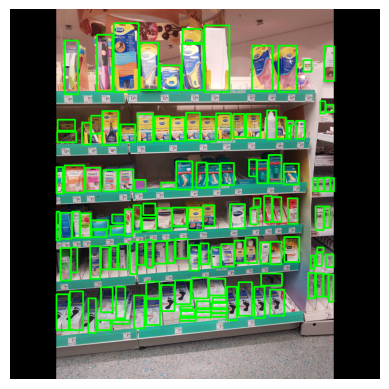

Number of labels = 125


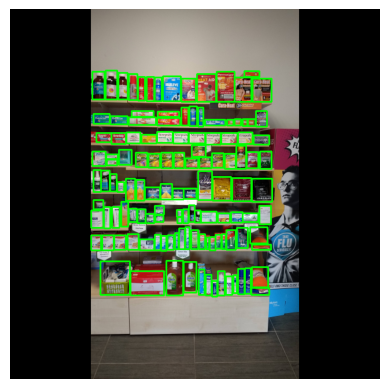

Number of labels = 141


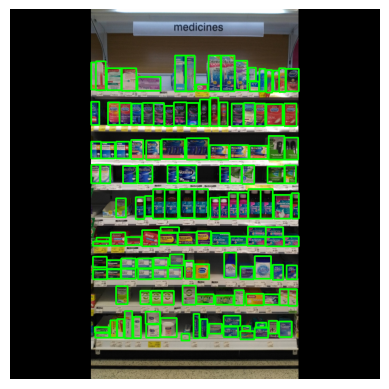

Number of labels = 101


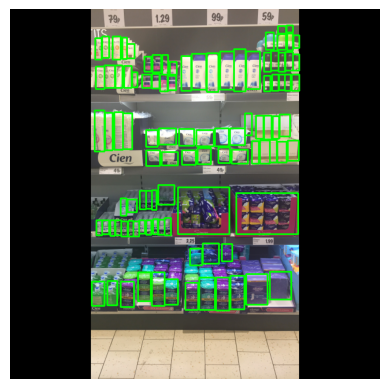

Number of labels = 231


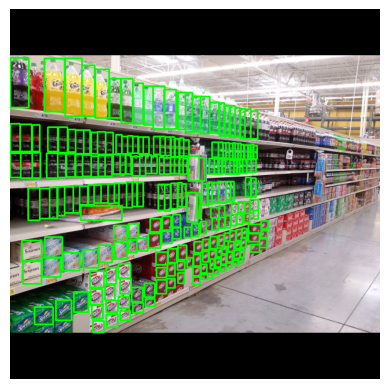

In [10]:
def draw_one_image_with_bboxes (image, bounding_boxes):
    print(f"Number of labels = {len(bounding_boxes)}")
    # Draw each bounding box on the image
    for bbox in bounding_boxes:
        _, x_center, y_center, width, height = bbox
        scale_y, scale_x = image.shape[:2]

        x_min = int((x_center - width / 2) * scale_x)
        y_min = int((y_center - height / 2) * scale_y)
        x_max = int((x_center + width / 2) * scale_x)
        y_max = int((y_center + height / 2) * scale_y)

        # Draw the rectangle (Bounding Box)
        start_point = (x_min, y_min)
        end_point = (x_max, y_max)
        # print(start_point, end_point)
        color = (0, 255, 0)  # Green color for the bounding box
        thickness = 2
        image = cv2.rectangle(image, start_point, end_point, color, thickness)

    # Convert the image from BGR to RGB (OpenCV loads in BGR by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide the axes
    plt.show()

for i in range(5):
    draw_one_image_with_bboxes (image_objects[i], bbox_objects[i])

In [ ]:
def write_train_yaml(yaml_name, full_dataset=False):
    with open(yaml_name, 'w') as fp:
        if full_dataset:
            fp.write(f"path: {path}/SKU110K_fixed/\n")
        else:
            fp.write(f"path: ../02_preprocess/\n")
        fp.write(f"train: images/train\n")
        fp.write(f"val: images/val\n")
        fp.write(f"nc: 1\n")
        fp.write(f"names: ['object']")

write_train_yaml("train.yaml", full_dataset=False)

In [ ]:
# model = YOLO('weights/epoch14.pt')
model = YOLO('yolo11n.pt')

# for name, param in model.named_parameters():
#     print(f"{name}: requires_grad={param.requires_grad}")

train_results = model.train(
    data="train.yaml",  # path to dataset YAML
    epochs=10,  # number of training epochs
    imgsz=640,  # training image size
    # device="mps",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
    device="cpu",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
    # device=0,  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
    save_period=1,
    # exist_ok=True,
    freeze = 10,
)


New https://pypi.org/project/ultralytics/8.3.32 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.18 🚀 Python-3.11.10 torch-2.5.0 MPS (Apple M2)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=train.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=mps, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fals

train: Scanning /Users/chenarei/GitHub/store-shelves-detector/02_preprocess/labels/train.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
val: Scanning /Users/chenarei/GitHub/store-shelves-detector/02_preprocess/labels/val.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]

Plotting labels to runs/detect/train13/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train13
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      5.31G      2.622      3.527      1.664        947        640: 100%|██████████| 3/3 [00:43<00:00, 14.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]

                   all         10       1375      0.044      0.096     0.0241     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/3 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [16]:
# Evaluate model performance on the validation set
metrics = model.val()

Ultralytics 8.3.18 🚀 Python-3.11.10 torch-2.5.0 MPS (Apple M2)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /Users/chenarei/GitHub/store-shelves-detector/02_preprocess/labels/val.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.500s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.37s/it]


                   all         10       1375      0.335      0.146      0.242      0.113
Speed: 0.6ms preprocess, 114.3ms inference, 0.0ms loss, 278.2ms postprocess per image
Results saved to runs/detect/train112


In [14]:
# Save the trained model
model.save('latest.pt')

In [15]:
def predict(image_source):
    # Load trained model (optional)
    model = YOLO('latest.pt')

    # Predict your image and save to ./runs/prdict{n} folder
    results = model.predict(
        source=image_source,         # Path to your input image
        conf=0.4,                    # Confidence threshold for predictions
        save=False,                  # Save the output image
        line_width=2,                # Line thickness for bounding boxes
        show_labels=True,           # Hide the class labels
        show_conf=True              # Hide the confidence scores
    )

    return results

# Test by predict an image
# results = predict(image_paths[-1])
image_path = path+"/SKU110K_fixed/images/test/test_256.jpg"
results = predict(image_path)
# Show result on the screen
results[0].show()


image 1/1 /Users/chenarei/.cache/kagglehub/datasets/thedatasith/sku110k-annotations/versions/14/SKU110K_fixed/images/test/test_256.jpg: 640x480 43 objects, 62.6ms
Speed: 3.1ms preprocess, 62.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


144 139


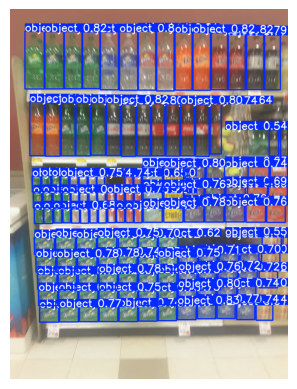

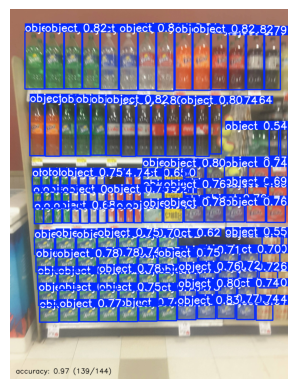

In [ ]:
def overlay_text(image, texts):
    # Define text properties   
    position = (50, image.shape[0]-50)  # (x, y) coordinates of the bottom-left corner of the text
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2  # Scale of the font size
    color = (0, 0, 0)  # Text color in BGR (white)
    thickness = 4  # Thickness of the text

    for text in texts:
        # Overlay the text on the image
        image_with_text = cv2.putText(image, text, position, font, font_scale, color, thickness)
    return image_with_text

def show_images(input_image):
    # Display the image using matplotlib
    image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

label_path = path+"/SKU110K_fixed/labels/test/test_256.txt"
with open(label_path, 'r') as fp:
    labels = fp.readlines()
golden_boxes = len(labels)
detected_boxes = len(results[0].boxes)
print(golden_boxes, detected_boxes)
image = results[0].plot()
show_images(image)


image = overlay_text(image, [f'accuracy: {round(detected_boxes/golden_boxes, 2)} ({detected_boxes}/{golden_boxes})'])
show_images(image)

# Display the image
# cv2.imshow('Image with Text', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()